# Initialization

In [26]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

from efficientnet_pytorch import EfficientNet

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {DEVICE}")

PyTorch version: 2.3.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [27]:
# check folders in dataset folders
import os

PATH = "/Users/wyattcheang/retinal-model/preprocessed_data"
CLASSES = os.listdir(PATH)# Create a dictionary with elements as keys and their indices as values
INDEX_DICTS = {elem: idx for idx, elem in enumerate(CLASSES)}
CLASSES, INDEX_DICTS

(['CNV', 'DME', 'DRUSEN', 'NORMAL'],
 {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3})

In [28]:
SEED = 42
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data Loading

In [29]:
import os
import pandas as pd

# Define the path to the directory containing the images organized by labels
path = "/Users/wyattcheang/retinal-model/preprocessed_data"

# Prepare an empty DataFrame to store images and respective labels
data = pd.DataFrame(columns=['Path', 'Label'])

# Iterate over each directory (each directory represents a label)
for label in os.listdir(path):
    # Skip .DS_Store file if present
    if label == ".DS_Store":
        continue
    
    # Construct the full path to the current label directory
    label_dir = os.path.join(path, label)
    
    # Initialize lists to store image data
    image_paths = []
    
    # Iterate over each image file in the current directory
    for image in os.listdir(label_dir):
        if image.endswith((".jpeg", ".jpg", ".png")):
            # Read the image data and add it to the list
            image_paths.append(os.path.join(label_dir, image))
        
    df = pd.DataFrame(data={"Path": image_paths})
    df["Label"] = label

    # Merge with existing data
    data = pd.concat([data, df], ignore_index=True)

# Display the DataFrame
print("Images loaded successfully into DataFrame")
print("Number of images:", len(data))
display(data)

Images loaded successfully into DataFrame
Number of images: 76902


,Path,Label
0,/Users/wyattcheang/retinal-model/preprocessed_...,CNV
1,/Users/wyattcheang/retinal-model/preprocessed_...,CNV
2,/Users/wyattcheang/retinal-model/preprocessed_...,CNV
3,/Users/wyattcheang/retinal-model/preprocessed_...,CNV
4,/Users/wyattcheang/retinal-model/preprocessed_...,CNV
...,...,...
76897,/Users/wyattcheang/retinal-model/preprocessed_...,NORMAL
76898,/Users/wyattcheang/retinal-model/preprocessed_...,NORMAL
76899,/Users/wyattcheang/retinal-model/preprocessed_...,NORMAL
76900,/Users/wyattcheang/retinal-model/preprocessed_...,NORMAL


In [30]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [31]:
def transform_image(image):
    image = image.float() / 255.0
    return image

def get_class_index(label):
    return CLASSES.index(label)

# Create custom dataset
custom_dataset = CustomImageDataset(annotations_file=data, 
                                    img_dir=path, transform=transform_image, target_transform=get_class_index)

# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(custom_dataset))
val_size = int(0.15 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [train_size, val_size, test_size])

In [32]:
# Access an example image and label from the training dataset
image, label = train_dataset[0]
print("Image shape:", image.shape)

Image shape: torch.Size([3, 224, 224])


In [33]:
# See the first training example
image, label = train_dataset[0]
image, label

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.8392, 0.0627, 0.0784,  ..., 0.0745, 0.0392, 0.0549],
          [0.8431, 0.0667, 0.0627,  ..., 0.0667, 0.0431, 0.0510],
          [0.8431, 0.0588, 0.0431,  ..., 0.0824, 0.0706, 0.0549]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.8392, 0.0627, 0.0784,  ..., 0.0745, 0.0392, 0.0549],
          [0.8431, 0.0667, 0.0627,  ..., 0.0667, 0.0431, 0.0510],
          [0.8431, 0.0588, 0.0431,  ..., 0.0824, 0.0706, 0.0549]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

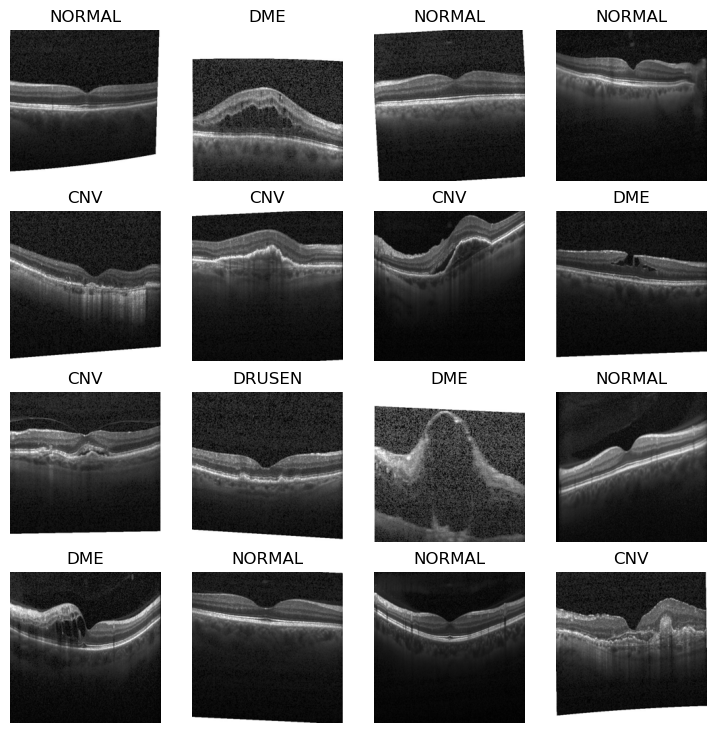

In [34]:
# Plot more images
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range (1, rows*cols+1):
    random_index = torch.randint(0, len(train_dataset), size=(1,)).item()   # `item()` to get the value from tensor instead of tensor
    image, label = train_dataset[random_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.permute(1, 2, 0), cmap="gray")
    plt.title(CLASSES[label])
    plt.axis("off")

In [35]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn train dataset into DataLoader
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataloader, validation_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x458042d90>,
 <torch.utils.data.dataloader.DataLoader at 0x458042ee0>)

In [36]:
# Check out what is inside the dataloader
print(f"DataLoader: {train_dataloader, test_dataloader, validation_dataloader}")
print(f"Length of DataLoader: {len(train_dataloader), len(test_dataloader), len(validation_dataloader)}")
print(f"Batch size of DataLoader: {train_dataloader.batch_size, test_dataloader.batch_size, validation_dataloader.batch_size}")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x458042d90>, <torch.utils.data.dataloader.DataLoader object at 0x458042ee0>, <torch.utils.data.dataloader.DataLoader object at 0x458042b20>)
Length of DataLoader: (1683, 361, 361)
Batch size of DataLoader: (32, 32, 32)


In [37]:
def transform_image(image):
    image = image.float() / 255.0
    return image

def get_class_index(label):
    return CLASSES.index(label)

# Create custom dataset
custom_dataset = CustomImageDataset(annotations_file=data, 
                                    img_dir=path, transform=transform_image, target_transform=get_class_index)

# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(custom_dataset))
val_size = int(0.15 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [train_size, val_size, test_size])

# Model 1: EfficientNet

In [38]:
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [39]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [40]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EffNet(nn.Module):
    def __init__(self, num_classes):
        super(EffNet, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')  # Change the model type if needed
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)


In [41]:
effnet = EffNet(num_classes=len(CLASSES))
effnet

Loaded pretrained weights for efficientnet-b0


EffNet(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
     

In [42]:
from torchmetrics import Accuracy

optimizer = torch.optim.Adam(effnet.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task="multiclass", num_classes=len(CLASSES)).to(DEVICE)

In [43]:
from helper import train_model, eval_model
### Train the model
# Import tqdm for progress bar
from tqdm.auto import tqdm
from helper import timer

EPOCH = 5

start_time = timer()

torch.manual_seed(42)
effnet.to(DEVICE)
for epoch in tqdm(range(1, EPOCH + 1), desc="Epoch"):
    train_model(model=effnet,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=DEVICE,
               epoch=epoch)
    eval_model(model=effnet,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=DEVICE,
              epoch=epoch)
    
end_time = timer()

Elapsed time: 0.0 seconds


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training | Epoch: 1:   0%|          | 0/1683 [00:00<?, ?it/s]

Test loss: 0.3235, Test Acc: 0.8931




Evaluating | Epoch: 1:   0%|          | 0/361 [00:00<?, ?it/s]

Test loss: 0.3082, Test Acc: 0.9182




Training | Epoch: 2:   0%|          | 0/1683 [00:00<?, ?it/s]

Test loss: 0.2128, Test Acc: 0.9296




Evaluating | Epoch: 2:   0%|          | 0/361 [00:00<?, ?it/s]

Test loss: 0.2671, Test Acc: 0.9175




Training | Epoch: 3:   0%|          | 0/1683 [00:00<?, ?it/s]

Test loss: 0.1901, Test Acc: 0.9384




Evaluating | Epoch: 3:   0%|          | 0/361 [00:00<?, ?it/s]

Test loss: 0.2636, Test Acc: 0.9159




Training | Epoch: 4:   0%|          | 0/1683 [00:00<?, ?it/s]

Test loss: 0.1696, Test Acc: 0.9440




Evaluating | Epoch: 4:   0%|          | 0/361 [00:00<?, ?it/s]

Test loss: 0.2284, Test Acc: 0.9249




Training | Epoch: 5:   0%|          | 0/1683 [00:00<?, ?it/s]

Test loss: 0.1536, Test Acc: 0.9490




Evaluating | Epoch: 5:   0%|          | 0/361 [00:00<?, ?it/s]

Test loss: 0.2597, Test Acc: 0.9111


Elapsed time: 9.5367431640625e-07 seconds


### Save model

In [45]:
from pathlib import Path

# Create a directory to save model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "effnetv1.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# Save the model
torch.save(effnet.state_dict(), MODEL_SAVE_PATH)

### Model evaluation

In [53]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_label = []
y_preds = []
effnet.eval()
with torch.inference_mode():
  for (X, y) in tqdm(validation_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(DEVICE), y.to(DEVICE)
    # Do the forward pass
    y_logit = effnet(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    y_label.append(y.cpu())


Making predictions:   0%|          | 0/361 [00:00<?, ?it/s]

In [55]:
y_preds = torch.cat(y_preds)
y_label = torch.cat(y_label)

#### Confusion Matrix

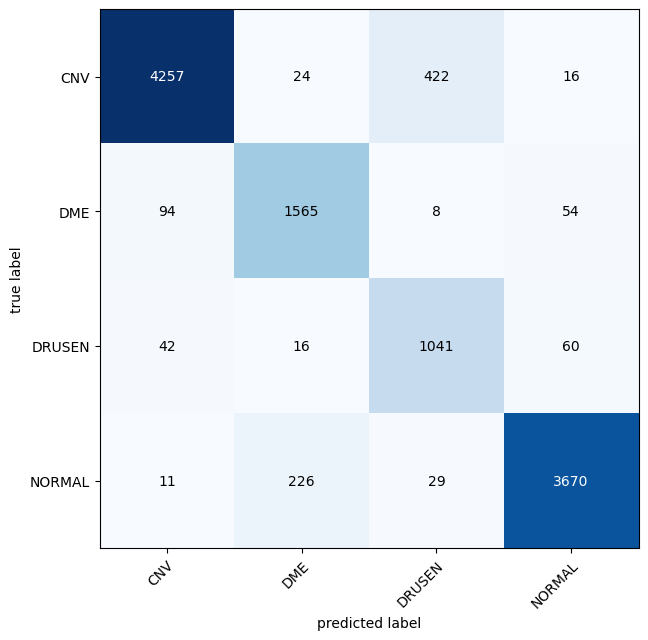

In [56]:
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(CLASSES), task="multiclass")
confmat_tensor = confmat(preds=y_preds, 
                         target=y_label)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), 
                                class_names=CLASSES, 
                                figsize=(10, 7))

In [59]:
from sklearn.metrics import classification_report

num_classes = len(CLASSES)
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_label, y_preds, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.97      0.90      0.93      4719
     Class 1       0.85      0.91      0.88      1721
     Class 2       0.69      0.90      0.78      1159
     Class 3       0.97      0.93      0.95      3936

    accuracy                           0.91     11535
   macro avg       0.87      0.91      0.89     11535
weighted avg       0.92      0.91      0.92     11535



In [58]:
effnet

EffNet(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
     

In [ ]:
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

class MyModule(LightningModule):
    def __init__(self, num_classes: int):
        super().__init__()
        metrics = MetricCollection([
            MulticlassAccuracy(num_classes), 
            MulticlassPrecision(num_classes), 
            MulticlassRecall(num_classes),
            MulticlassF1Score(num_classes)
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.valid_metrics = metrics.clone(prefix='val_')

    def training_step(self, batch, batch_idx):
        logits = self(x)
        # ...
        output = self.train_metrics(logits, y)
        # use log_dict instead of log
        # metrics are logged with keys: train_Accuracy, train_Precision and train_Recall
        self.log_dict(output)

    def validation_step(self, batch, batch_idx):
        logits = self(x)
        # ...
        self.valid_metrics.update(logits, y)

    def on_validation_epoch_end(self):
        # use log_dict instead of log
        # metrics are logged with keys: val_Accuracy, val_Precision and val_Recall
        output = self.valid_metrics.compute()
        self.log_dict(output)
        # remember to reset metrics at the end of the epoch
        self.valid_metrics.reset()

In [68]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

ModuleNotFoundError: No module named 'tensorflow'